In [3]:
import numpy as np
from tqdm import tqdm
import random, math
from sklearn.preprocessing import LabelBinarizer
from matplotlib import pyplot as plt

sigmoid = lambda x: 1/(1+np.exp(-x))

def accuracy_score(y_true, pred):
    return (y_true == pred).mean()*100

class logistic_reg:
    
    def __init__(self, alpha=0.001, C=50, preprocessors=[], patience=10):
        self.alpha=alpha
        self.C=C
        self.lb=LabelBinarizer()
        self.preprocessors=preprocessors
        self.patience=patience
        pass
    
    def earlystop(self, losses):
        if len(losses)<self.patience:
            return False
        return all(losses[-1] >= loss for loss in losses[-(self.patience+1):-1])
    
    def plot(self, accuracies, losses):
        plt.style.use('dark_background')
        fig, ax =  plt.subplots(1,2, figsize=(10, 6))
        ax[0].plot(accuracies, color='yellow')
        ax[0].set_title('Accuracy Plot'), ax[0].set_xlabel('Epochs'), ax[0].set_ylabel('accuracy')
        ax[1].plot(losses, color='yellow')
        ax[1].set_title('Loss Plot'), ax[1].set_xlabel('Epochs'), ax[1].set_ylabel('loss')
        plt.show()
        
    def computeCost(self, y, yhat):
        return (-y * np.log(yhat) - (1 - y)*np.log(1 - yhat)).mean() + np.linalg.norm(self.params)**2/self.C

    def _gen_batch(self, batch_size, no_of_samples, *args):
        i=0
        for j in range(math.ceil(no_of_samples/batch_size)):
            yield [arg[i:min(i+batch_size, no_of_samples)] for arg in args]
            i+=batch_size        
    
    def fit(self, X, Class, epochs=20000, batch_size=32, plot=True):
        
        alpha=self.alpha
        C=self.C
        
        X=np.array(X)
        for pp in self.preprocessors:
            X=pp.fit_transform(X)
            
        Class=np.array(Class)
        y=self.lb.fit_transform(Class)       
        num_of_samples, no_of_classes = y.shape
        biased_X=np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        self.params=np.random.rand(no_of_classes, X.shape[1]+1)       
        
        accuracies, losses = [], []
        pbar=tqdm(range(epochs), position=0, leave=True)
        for epoch in pbar:           
            indices=np.array(range(num_of_samples))
            random.shuffle(indices)
            biased_X = biased_X[indices]
            y = y[indices]
            
            for batch_biased_X, batch_y in self._gen_batch(batch_size, num_of_samples, biased_X, y):
                yhat=sigmoid(np.matmul(batch_biased_X, self.params.T))
                deviation=yhat-batch_y
                cost=self.computeCost(batch_y, yhat)
                delta_params=(2/C)*self.params.T + 2*batch_biased_X.T.dot(deviation)/num_of_samples
                self.params=self.params-alpha*delta_params.T
            yhat=sigmoid(np.matmul(biased_X, self.params.T))
            cur_cost=(-y * np.log(yhat) - (1 - y)*np.log(1 - yhat)).mean()
            predClass=self.lb.inverse_transform(yhat)
            ytrue=self.lb.inverse_transform(y)
            accuracy=accuracy_score(predClass, ytrue)
            pbar.set_description("Accuracy {:.2f} Loss {:.2f}".format(accuracy, cur_cost))
            accuracies.append(accuracy), losses.append(cur_cost)
            if self.patience and self.earlystop(losses):
                print(f'Early stopping, loss traceback: {losses[-(self.patience+1):]}')
                break
        if plot:
            self.plot(accuracies, losses)
            
    def predict(self, Xpred):
        biased_Xpred=np.concatenate([np.ones((Xpred.shape[0], 1)), Xpred], axis=1)
        return sigmoid(np.matmul(biased_Xpred, self.params.T))
    
    def predict_classes(self, Xpred):
        for pp in self.preprocessors:
            Xpred=pp.transform(Xpred)
        pred=self.predict(Xpred)
        return self.lb.inverse_transform(pred)
    
    def score(self, predX, y_true):
        pred=self.predict_classes(predX)
        return accuracy_score(y_true, pred)

Accuracy 93.41 Loss 0.51:  88%|██████████████████████████████████████████▉      | 17517/20000 [01:16<00:10, 230.11it/s]


Early stopping, loss traceback: [0.5091637619842064, 0.5091637611340992, 0.5091637604590479, 0.5091637614433489, 0.5091637610596935, 0.5091637617976216, 0.5091637613294373, 0.5091637617066263, 0.5091637631766031, 0.5091637629307877, 0.5091637637694921]


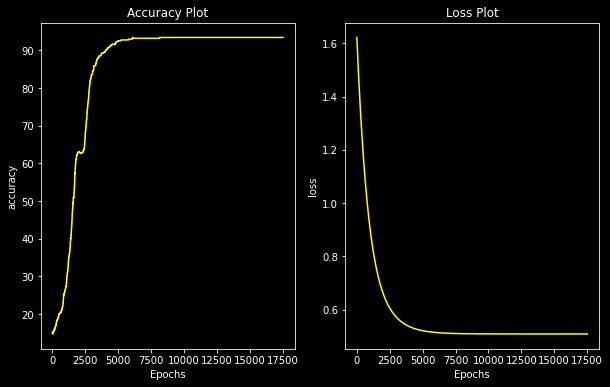

(93.85964912280701, 93.4065934065934)

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer

plt.style.use('dark_background')
X, y = load_breast_cancer(return_X_y=True)
trainX, testX, trainY, testY = train_test_split(X, y, random_state=28, test_size=0.2)

cls=logistic_reg(preprocessors=[StandardScaler(), Normalizer()])
cls.fit(trainX, trainY)
cls.score(testX, testY), cls.score(trainX, trainY)